# Context Length Ablation Study

This notebook analyzes the impact of different context lengths on model performance.


## Load and Process Data


In [1]:
import os
from dotenv import load_dotenv
from tabpfn_time_series.experimental.visualization.data_processing import load_wandb_runs

load_dotenv()

df = load_wandb_runs(
    entity=os.getenv("WANDB_ENTITY"),
    project=os.getenv("WANDB_PROJECT_FEATURE_ABLATION"),
    tags=["context-length"],
)

Fetching runs from W&B...
Found 340 runs in 30.60 seconds
Extracting basic run info...


Extracting run info: 100%|██████████| 340/340 [00:11<00:00, 30.09it/s]


Done extracting run info for 340 runs in 11.30 seconds


Processing runs: 100%|██████████| 340/340 [00:00<00:00, 319888.60it/s]


In [2]:
from tabpfn_time_series.experimental.visualization.data_processing import (
    rename_config_names
)

# Define config name mapping
config_rename_dict = {
    "index-calendar-auto-10000": "10000",
    "second-minute-paper-auto-seasonal-linear-pad-2-ex0": "4096",
    "index-calendar-auto-1024": "1024",
    "index-calendar-auto-2048": "2048",
}

# Rename configurations
df = rename_config_names(df, config_rename_dict)


## Import Seasonal Naive Results


In [3]:
import pandas as pd
from tabpfn_time_series.experimental.visualization.data_processing import (
    load_external_results,
    get_common_subset
)

# Load external results
interested_models = ["Seasonal_Naive"]

external_df = load_external_results(
    interested_models=interested_models
)
# Combine with main DataFrame
df = pd.concat([df, external_df])
df = get_common_subset(df)


Number of datasets with all configurations completed: 80

Configurations per dataset:
config_name
10000             80
1024              80
2048              80
4096              80
Seasonal_Naive    80
dtype: int64


## Analyze Results


In [4]:
from tabpfn_time_series.experimental.visualization.metrics import (
    normalize_metric_by_baseline,
    gmean_and_ci
)

# Normalize metrics
normalized_mase_df = normalize_metric_by_baseline(df, metric='MASE_0.5', baseline_model='Seasonal_Naive')
normalized_wql_df = normalize_metric_by_baseline(df, metric='wSQL_mean', baseline_model='Seasonal_Naive')

# Calculate geometric means and confidence intervals
norm_wql_mean_and_ci = normalized_wql_df.groupby('config_name').apply(lambda x: gmean_and_ci(x['wSQL_mean']))
norm_mase_mean_and_ci = normalized_mase_df.groupby('config_name').apply(lambda x: gmean_and_ci(x['MASE_0.5']))


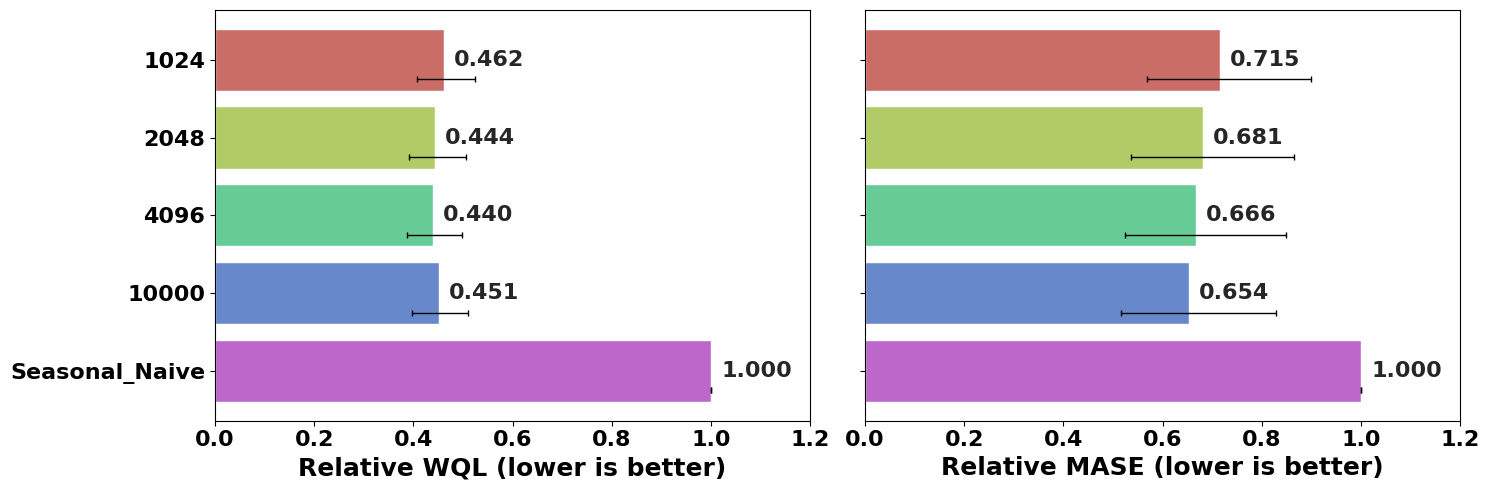

In [5]:
import matplotlib.pyplot as plt
from tabpfn_time_series.experimental.visualization.plotting import (
    plot_metric_comparison,
    save_plot_to_pdf,
)

# Define feature groups for plotting
feature_groups = [
    "1024",
    "2048",
    "4096",
    "10000",
    "Seasonal_Naive",
]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot WQL comparison
plot_metric_comparison(
    norm_wql_mean_and_ci,
    xaxis_label="Relative WQL (lower is better)",
    feature_groups=feature_groups,
    ax=axes[0]
)

# Plot MASE comparison
plot_metric_comparison(
    norm_mase_mean_and_ci,
    xaxis_label="Relative MASE (lower is better)",
    feature_groups=feature_groups,
    ax=axes[1]
)

plt.tight_layout()
save_plot_to_pdf(fig, "context_length_ablation.pdf")
plt.show()
